In [4]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
import itertools
%matplotlib inline
sns.set()

In [5]:
data_sample = pd.read_csv('DataSample__201709211530.csv')
data_sample2 = pd.read_csv('DataSample__201710061552.csv',dtype={"value": str})
#data_sample2['value'] = pd.to_numeric(data_sample2['value'],errors='coerce')
#data_sample['value'] = pd.to_numeric(data_sample['value'],errors='coerce')
data_sample = data_sample.append(data_sample2)
data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])
data_sample['owner'].replace('00000000-5854-8d6f-b8eb-cf14a0f795df','00000000-56ff-538b-2223-e1800b5e3ddb',inplace=True)


types = data_sample['type'].unique()
types

for t in types:
    f = lambda x: float(x.replace(',',''))
    # checks if the values contain decimal points, and uses a float conversion if so
    for v in data_sample.loc[data_sample['type'] == t, 'value'].head():
        if '.' in v:
            f = lambda x: float(x.replace(',',''))
            break
    data_sample.loc[data_sample['type'] == t, 'value'] = data_sample.loc[data_sample['type'] == t, 'value'].map(f)
for col in ['startDate', 'endDate', 'createdAt', 'updatedAt']:
    data_sample[col] = pd.to_datetime(data_sample[col], format='%Y-%m-%d %X')
to_tdelta = lambda row: row['endDate'] - row['startDate']
data_sample['duration'] = data_sample.apply(to_tdelta, axis=1)
data_sample['day_of_week'] = data_sample['startDate'].dt.dayofweek
data_sample.head() #0 - 6 is monday - sunday 

,_id,owner,source,sourceId,sourceName,type,startDate,endDate,value,content,originalData,createdAt,updatedAt,duration,day_of_week
0,1ff0fb89-6e1b-4601-84d0-98c79fdc5f2e,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,A1DB680E-F9C4-4FA4-8818-1D35E398B5F0,Health Mate,health-bmi,2014-08-27 21:41:23,2014-08-27 21:41:23,26.7387,NaN,NaN,2017-08-31 11:20:49,2017-08-31 11:20:49,0 days,2
1,78219621-1da4-4e3b-87bc-f4885718c63f,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,2030515A-1C70-40F3-8470-BDE99ABFC906,Health Mate,health-weight,2014-08-27 21:41:23,2014-08-27 21:41:23,71.042,NaN,NaN,2017-08-31 11:20:58,2017-08-31 11:20:58,0 days,2
2,2d917e7e-0844-4f52-b15e-2a5346c96dda,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,96D21A44-67D7-412D-BF3A-543819A8EBF0,Health Mate,health-bmi,2014-08-28 06:24:53,2014-08-28 06:24:53,26.5866,NaN,NaN,2017-08-31 11:20:49,2017-08-31 11:20:49,0 days,3
3,ab800f4b-bef7-434e-8e57-e0fccc44bfb7,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,5D73FD9D-17E1-480C-9235-3E5036503E6A,Health Mate,health-body-fat,2014-08-28 06:24:53,2014-08-28 06:24:53,0.258699,NaN,NaN,2017-08-31 11:20:53,2017-08-31 11:20:53,0 days,3
4,fb2a0865-17c3-4ac0-a782-749cc7befe12,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,5A9AB03C-30C9-43B9-9742-02E237A6F36D,Health Mate,health-weight,2014-08-28 06:24:53,2014-08-28 06:24:53,70.638,NaN,NaN,2017-08-31 11:20:58,2017-08-31 11:20:58,0 days,3


In [6]:
x1 = data_sample.type
x2 = data_sample.value

types = ['health-bmi','health-body-fat','health-weight', 'health-step-count']
type(x1)

pandas.core.series.Series

In [7]:
def prepare_table(x, y,time='D',data_sample=data_sample):
    steps = data_sample[data_sample['type'] == x]
    bodyfat = data_sample[data_sample['type'] == y]


    steps.index = steps['startDate']
    bodyfat.index = bodyfat['startDate']


    steps['value'] = pd.to_numeric(steps['value'])
    steps = steps.loc[:,'value']
    if x == 'health-step-count':
        steps = steps.resample(time).sum()
    else:
        steps = steps.resample(time).mean()


    bodyfat['value'] = pd.to_numeric(bodyfat['value'])
    bodyfat = bodyfat.loc[:,'value']
    bodyfat = bodyfat.resample(time).mean()

    steps = steps.to_frame('first')
    steps['second'] = bodyfat
    
    return steps

In [8]:
def plotter(steps):
    steps = steps.dropna()
    x = steps['first'].values
    y = steps['second'].values
    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black')
    plt.plot(x, regr.predict(x), color='yellow', linewidth=2)
    
    corr_info = stats.stats.pearsonr(x, y)
    r = corr_info[0][0]
    p = corr_info[1][0]
    return r, p


In [9]:
users = data_sample['owner'].unique()
users

array(['00000000-56ff-538b-2223-e1800b5e3ddb',
       '00000000-5851-ee08-eb34-e20acc5af74e',
       '00000000-584e-1f39-bdee-d4102b989d01',
       '00000000-584d-a4f0-bdee-d4102b989ce5'], dtype=object)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


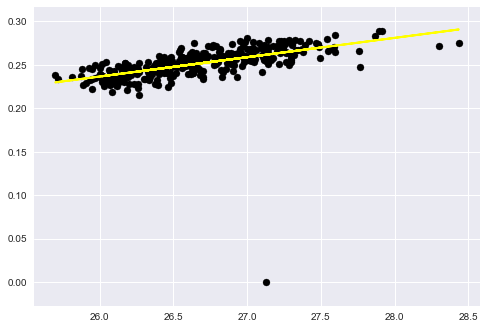

The r and p values for health-bmi and health-body-fat are: r = 0.532568808734 and p = 5.22578289277e-26


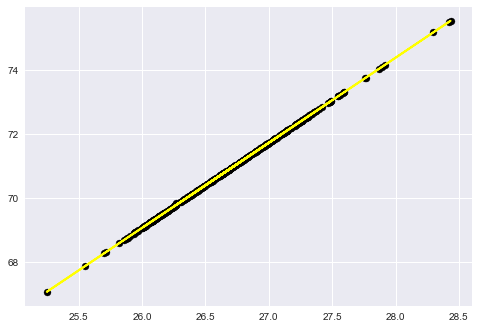

The r and p values for health-bmi and health-weight are: r = 0.999995296833 and p = 0.0


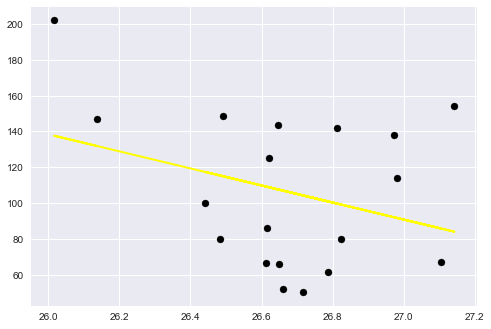

The r and p values for health-bmi and health-step-count are: r = -0.318125814695 and p = 0.184398003325


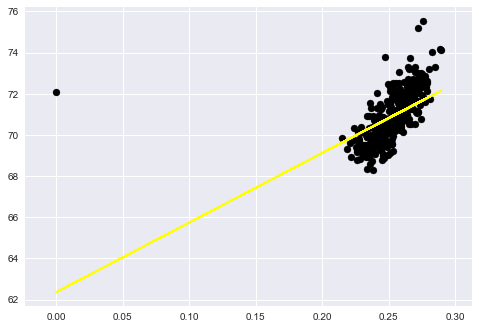

The r and p values for health-body-fat and health-weight are: r = 0.532307708737 and p = 5.5783269562e-26


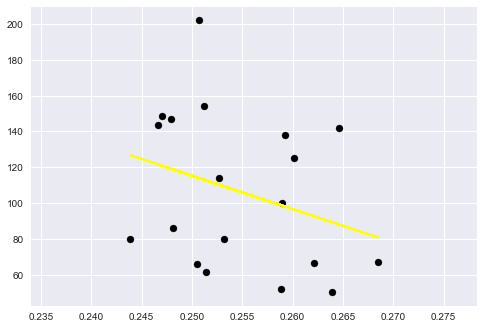

The r and p values for health-body-fat and health-step-count are: r = -0.306950484224 and p = 0.201157509409


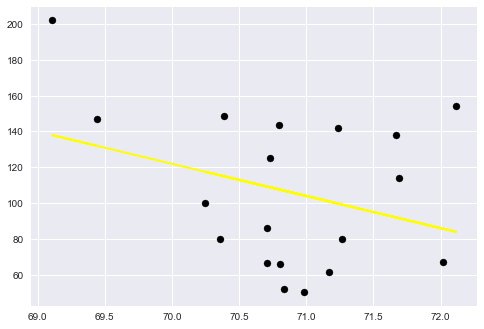

The r and p values for health-weight and health-step-count are: r = -0.319615437396 and p = 0.182237292507


In [10]:

for i in itertools.combinations(types, 2):
    t1 = i[0]
    t2 = i[1]
    a, b = plotter(prepare_table(t1, t2, data_sample=data_sample[data_sample['owner']==users[0]]))
    plt.show()
    print("The r and p values for {} and {} are: r = {} and p = {}".format(t1, t2, a, b))


In [11]:
bmi = data_sample[data_sample['type'] == 'health-bmi']
bmi.index = bmi['startDate']
bmi['value'] = pd.Series(bmi['value']).convert_objects(convert_numeric=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           value
count  38.000000
mean   26.657827
std     0.519584
min    25.671272
25%    26.196478
50%    26.691365
75%    27.061039
max    27.867441
           value
count  48.000000
mean   26.615515
std     0.477032
min    25.331828
25%    26.268160
50%    26.680382
75%    26.991077
max    27.469895


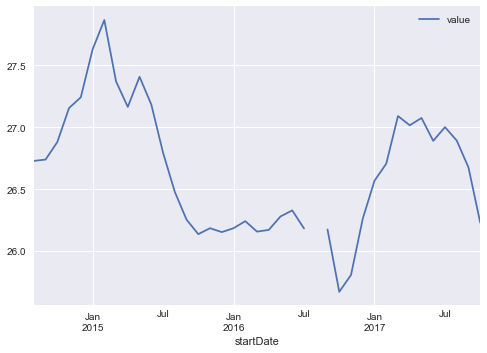

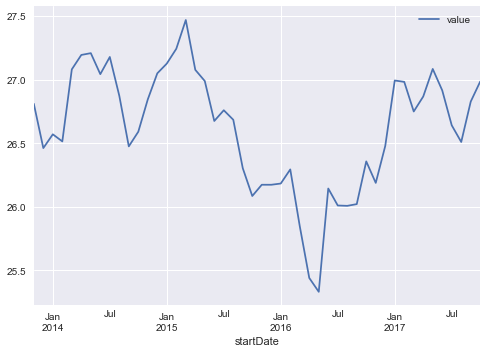

In [12]:
# BMI by month over the whole period
bmi_means = {}
for owner in bmi['owner'].unique():
    data_by_owner = bmi[bmi['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean()
    resampled_data.plot()
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']
    bmi_means[owner] = mean
    

In [13]:
for owner in bmi_means:
    print('Owner {} has monthly BMI mean of {}'.format(owner, bmi_means[owner]))

Owner 00000000-56ff-538b-2223-e1800b5e3ddb has monthly BMI mean of 26.6578270652
Owner 00000000-5851-ee08-eb34-e20acc5af74e has monthly BMI mean of 26.6155145882


           value
count  37.000000
mean   -0.000469
std     0.009063
min    -0.019238
25%    -0.006827
50%     0.000529
75%     0.005176
max     0.017613
           value
count  47.000000
mean    0.000190
std     0.010247
min    -0.016982
25%    -0.006328
50%     0.000372
75%     0.004706
max     0.032079


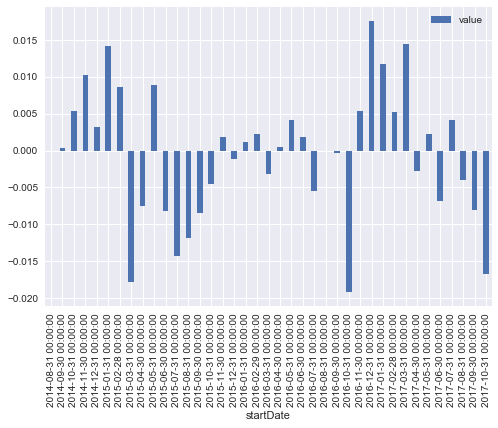

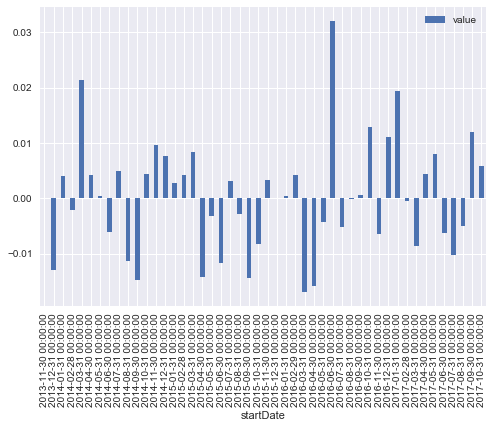

In [14]:
# pct_change slope comparison of each bmi
for owner in bmi['owner'].unique():
    data_by_owner = bmi[bmi['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean().pct_change()
    resampled_data.plot(kind='bar')
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']

In [15]:
weight = data_sample[data_sample['type'] == 'health-weight']
weight.index = weight['startDate']
weight['value'] = pd.Series(weight['value']).convert_objects(convert_numeric=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


           value
count  38.000000
mean   70.823191
std     1.381109
min    68.206003
25%    69.591991
50%    70.889640
75%    71.898472
max    74.041000
           value
count  48.000000
mean   86.234726
std     1.546358
min    82.075116
25%    85.108831
50%    86.444434
75%    87.453987
max    89.002454
           value
count  12.000000
mean   71.574003
std     3.471932
min    66.700759
25%    68.837036
50%    70.465419
75%    74.959217
max    76.257950
           value
count   1.000000
mean   54.431084
std          NaN
min    54.431084
25%    54.431084
50%    54.431084
75%    54.431084
max    54.431084


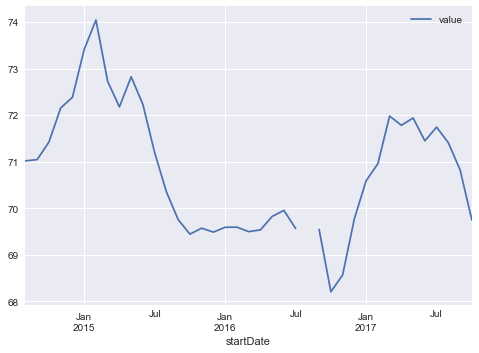

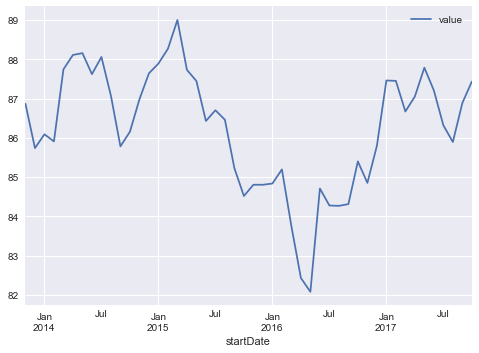

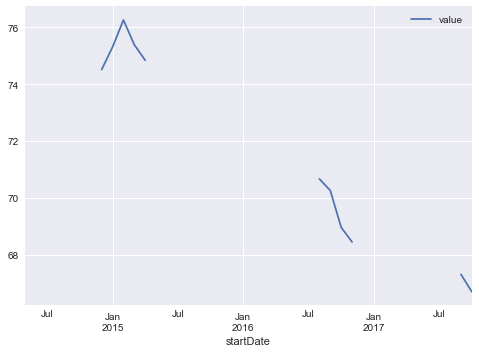

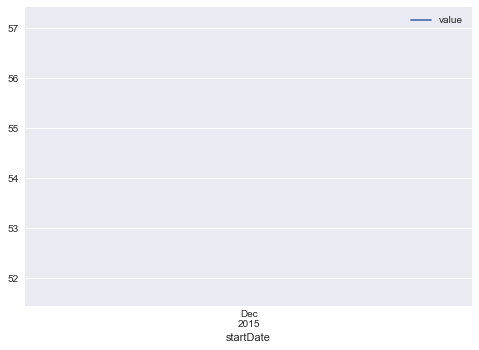

In [28]:
weight_info = {}
for owner in weight['owner'].unique():
    data_by_owner = weight[weight['owner'] == owner][['value']]
    resampled_data = data_by_owner.resample('M').mean()
    resampled_data.plot()
    print(resampled_data.describe())
    mean = resampled_data.describe().loc['mean', 'value']
    min_ = data_by_owner.describe().loc['min', 'value']
    max_ = data_by_owner.describe().loc['max', 'value']
    weight_info[owner] = {'mean': mean, 'min': min_, 'max': max_}

In [29]:
for owner in weight_info:
    print('Owner {} has monthly weight mean of {}, min of {}, max of {}'.format(owner, weight_info[owner]['mean'],  weight_info[owner]['min'],  weight_info[owner]['max']))

Owner 00000000-584d-a4f0-bdee-d4102b989ce5 has monthly weight mean of 71.5740032601, min of 65.997689835, max of 77.56429527
Owner 00000000-56ff-538b-2223-e1800b5e3ddb has monthly weight mean of 70.8231914399, min of 67.0790023804, max of 77.2030029297
Owner 00000000-5851-ee08-eb34-e20acc5af74e has monthly weight mean of 86.2347262945, min of 80.3640060425, max of 90.9640045166
Owner 00000000-584e-1f39-bdee-d4102b989d01 has monthly weight mean of 54.4310844, min of 54.4310844, max of 54.4310844
